In [1]:
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import torch
from tqdm import tqdm
import pandas as pd
tqdm.pandas()
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler
from transformers import BitsAndBytesConfig
import wandb
from dataset import build_dataset, collator

In [2]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [8]:
device = 'cuda' if torch.cuda.is_available() else "cpu" 

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("lvwerra/gpt2-imdb")
tokenizer.pad_token = tokenizer.eos_token

pretrained_model = AutoModelForCausalLM.from_pretrained('gpt2-rlhf',  device_map="auto")
model = AutoModelForCausalLMWithValueHead.from_pretrained(pretrained_model)
model.to(device)

# Load a reference model with a value head
ref_model = AutoModelForCausalLMWithValueHead.from_pretrained('reference_model')
ref_model.to(device)

generation_kwargs = {
    "min_length":-1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id
}

sent_kwargs = {
        "return_all_scores": True, 
        "function_to_apply": "none", 
        "batch_size": 16 
}


config = PPOConfig(
    model_name="lvwerra/gpt2-imdb", 
    learning_rate=1.5e-5
)

dataset = build_dataset(config)


sentiment_pipe = pipeline("sentiment-analysis", model="distilbert-imdb", device=device)

ppo_trainer = PPOTrainer(config, model, ref_model=ref_model, 
                         tokenizer=tokenizer, dataset=dataset, 
                         data_collator=collator)



Some weights of the model checkpoint at reference_model were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [6]:
def generate_responses(model, ppo_trainer, query_tensors, sample_size, device, generation_kwargs):
    response_tensors_ref, response_tensors = [], []
    for i in range(sample_size):
        gen_len = output_length_sampler()
        output = model.generate(torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device), **generation_kwargs).squeeze()[-gen_len:]
        response_tensors_ref.append(output)
        output = ppo_trainer.generate(torch.tensor(query_tensors[i]).to(device), **generation_kwargs).squeeze()[-gen_len:]
        response_tensors.append(output)
    return response_tensors_ref, response_tensors

def decode_responses(tokenizer, response_tensors):
    """Decode the list of response tensors into human-readable text."""
    return [tokenizer.decode(tensor) for tensor in response_tensors]

def reward_scores(sentiment_pipe, queries, responses, sent_kwargs):
    """Calculate sentiment scores for query-response pairs."""
    texts = [q + r for q, r in zip(queries, responses)]
    return [output[1]["score"] for output in sentiment_pipe(texts, **sent_kwargs)]


In [ ]:
model.eval()
sample_size = 40
output_length_sampler = LengthSampler(4, 16)
dataset.set_format("pandas")
df_batch = dataset[:].sample(sample_size)


result_data = {
    'query': df_batch['query'].tolist(),
    'input_ids': df_batch['input_ids'].tolist()
}


# Generate responses before and after training
response_tensors_ref, response_tensors = generate_responses(ref_model, ppo_trainer, result_data['input_ids'], sample_size, device, generation_kwargs)

# Decode responses
result_data['response (before)'] = decode_responses(tokenizer, response_tensors_ref)
result_data['response (after)'] = decode_responses(tokenizer, response_tensors)

# reward_scores
result_data['rewards (before)'] = reward_scores(sentiment_pipe, result_data['query'], result_data['response (before)'], sent_kwargs)
result_data['rewards (after)'] = reward_scores(sentiment_pipe, result_data['query'], result_data['response (after)'], sent_kwargs)

# Store results in a DataFrame
df_results = pd.DataFrame(result_data)
df_results

/root/miniconda3/lib/python3.8/site-packages/transformers/generation/utils.py:1156: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
print(f"The average reward before RLHF is {round(df_results['rewards (before)'].mean(), 3)}")

In [ ]:
print(f"The average reward after RLHF is {round(df_results['rewards (after)'].mean(), 3)}")

In [44]:
df_results.to_csv('ppo_result.csv')

### PPO Results

- The notebook utilizes the IMDb dataset to provide relevant training examples for the GPT-2 model, with adjustments made via PPO to optimize performance based on human feedback mechanisms.


### Training progress and outcomes are visualized through the following plots:

- **kl_divergence.png**: Displays the KL divergence, offering insights into the divergence between the policy and target distributions over training. From the picture, the KL divergence trend is steadily increasing, suggesting that the model's policy is continuously learning while maintaining a controlled divergence from the baseline policy.

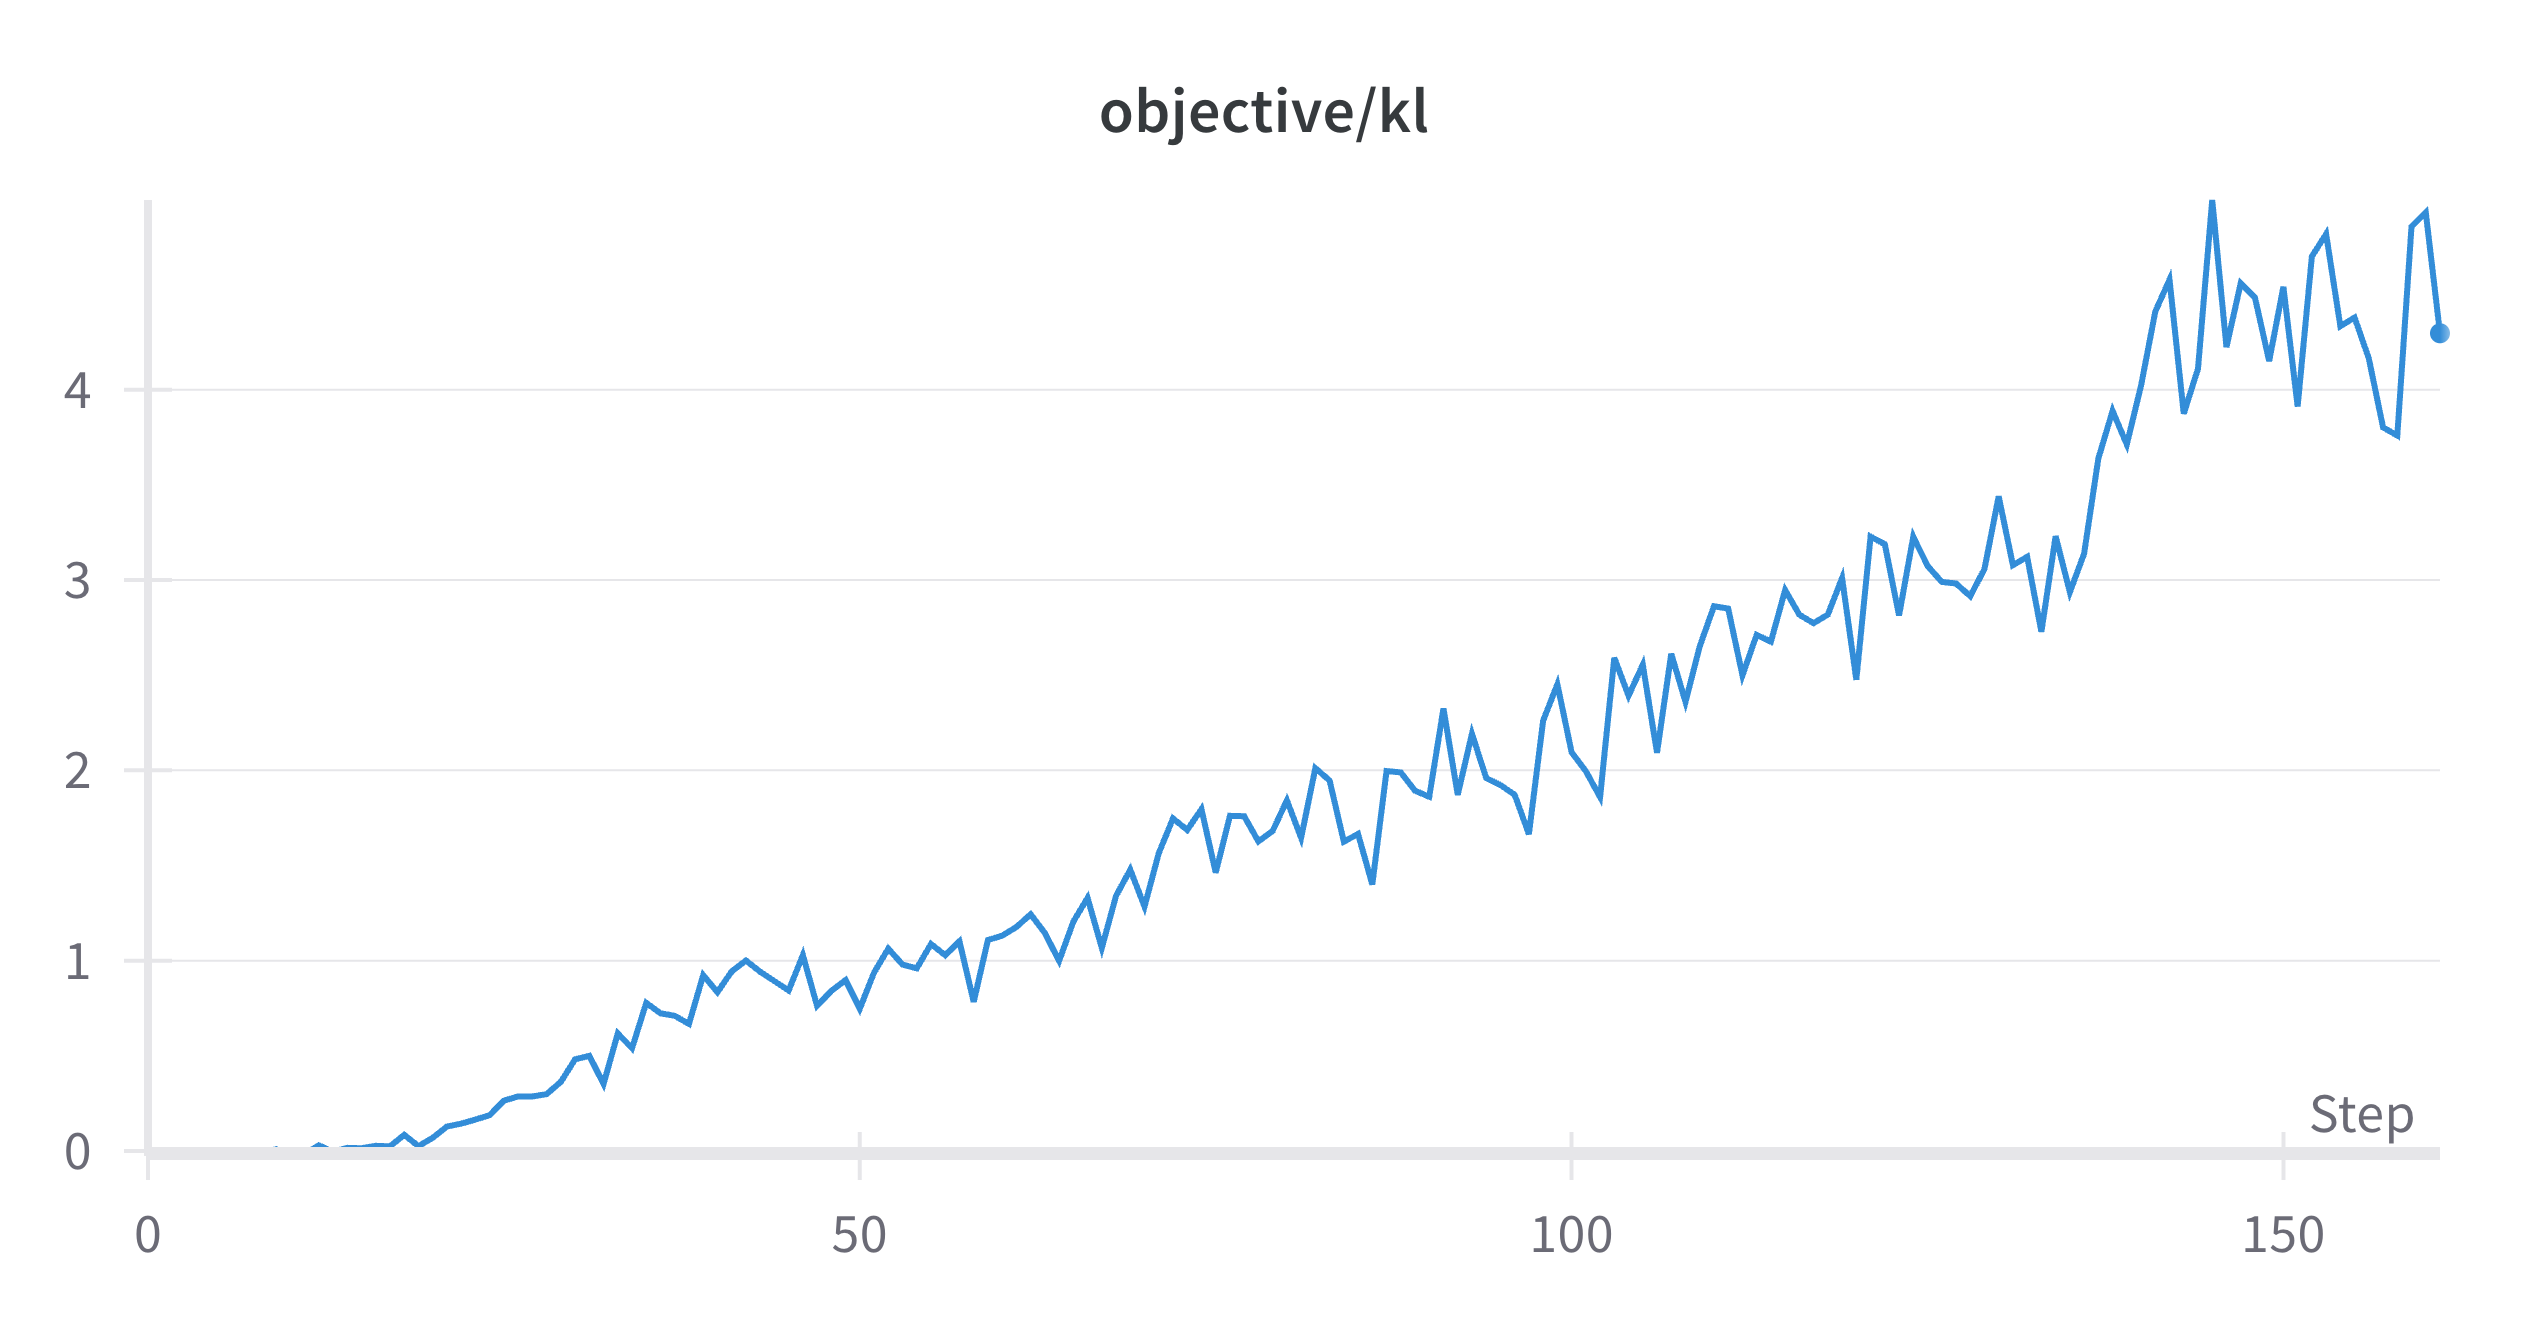



- **ppo_loss.png**: Shows the PPO loss, tracking how well the model minimizes its error across training epochs. From the picture, the PPO loss decreases over time, which signifies that the model is effectively learning and optimizing its predictions throughout the training.
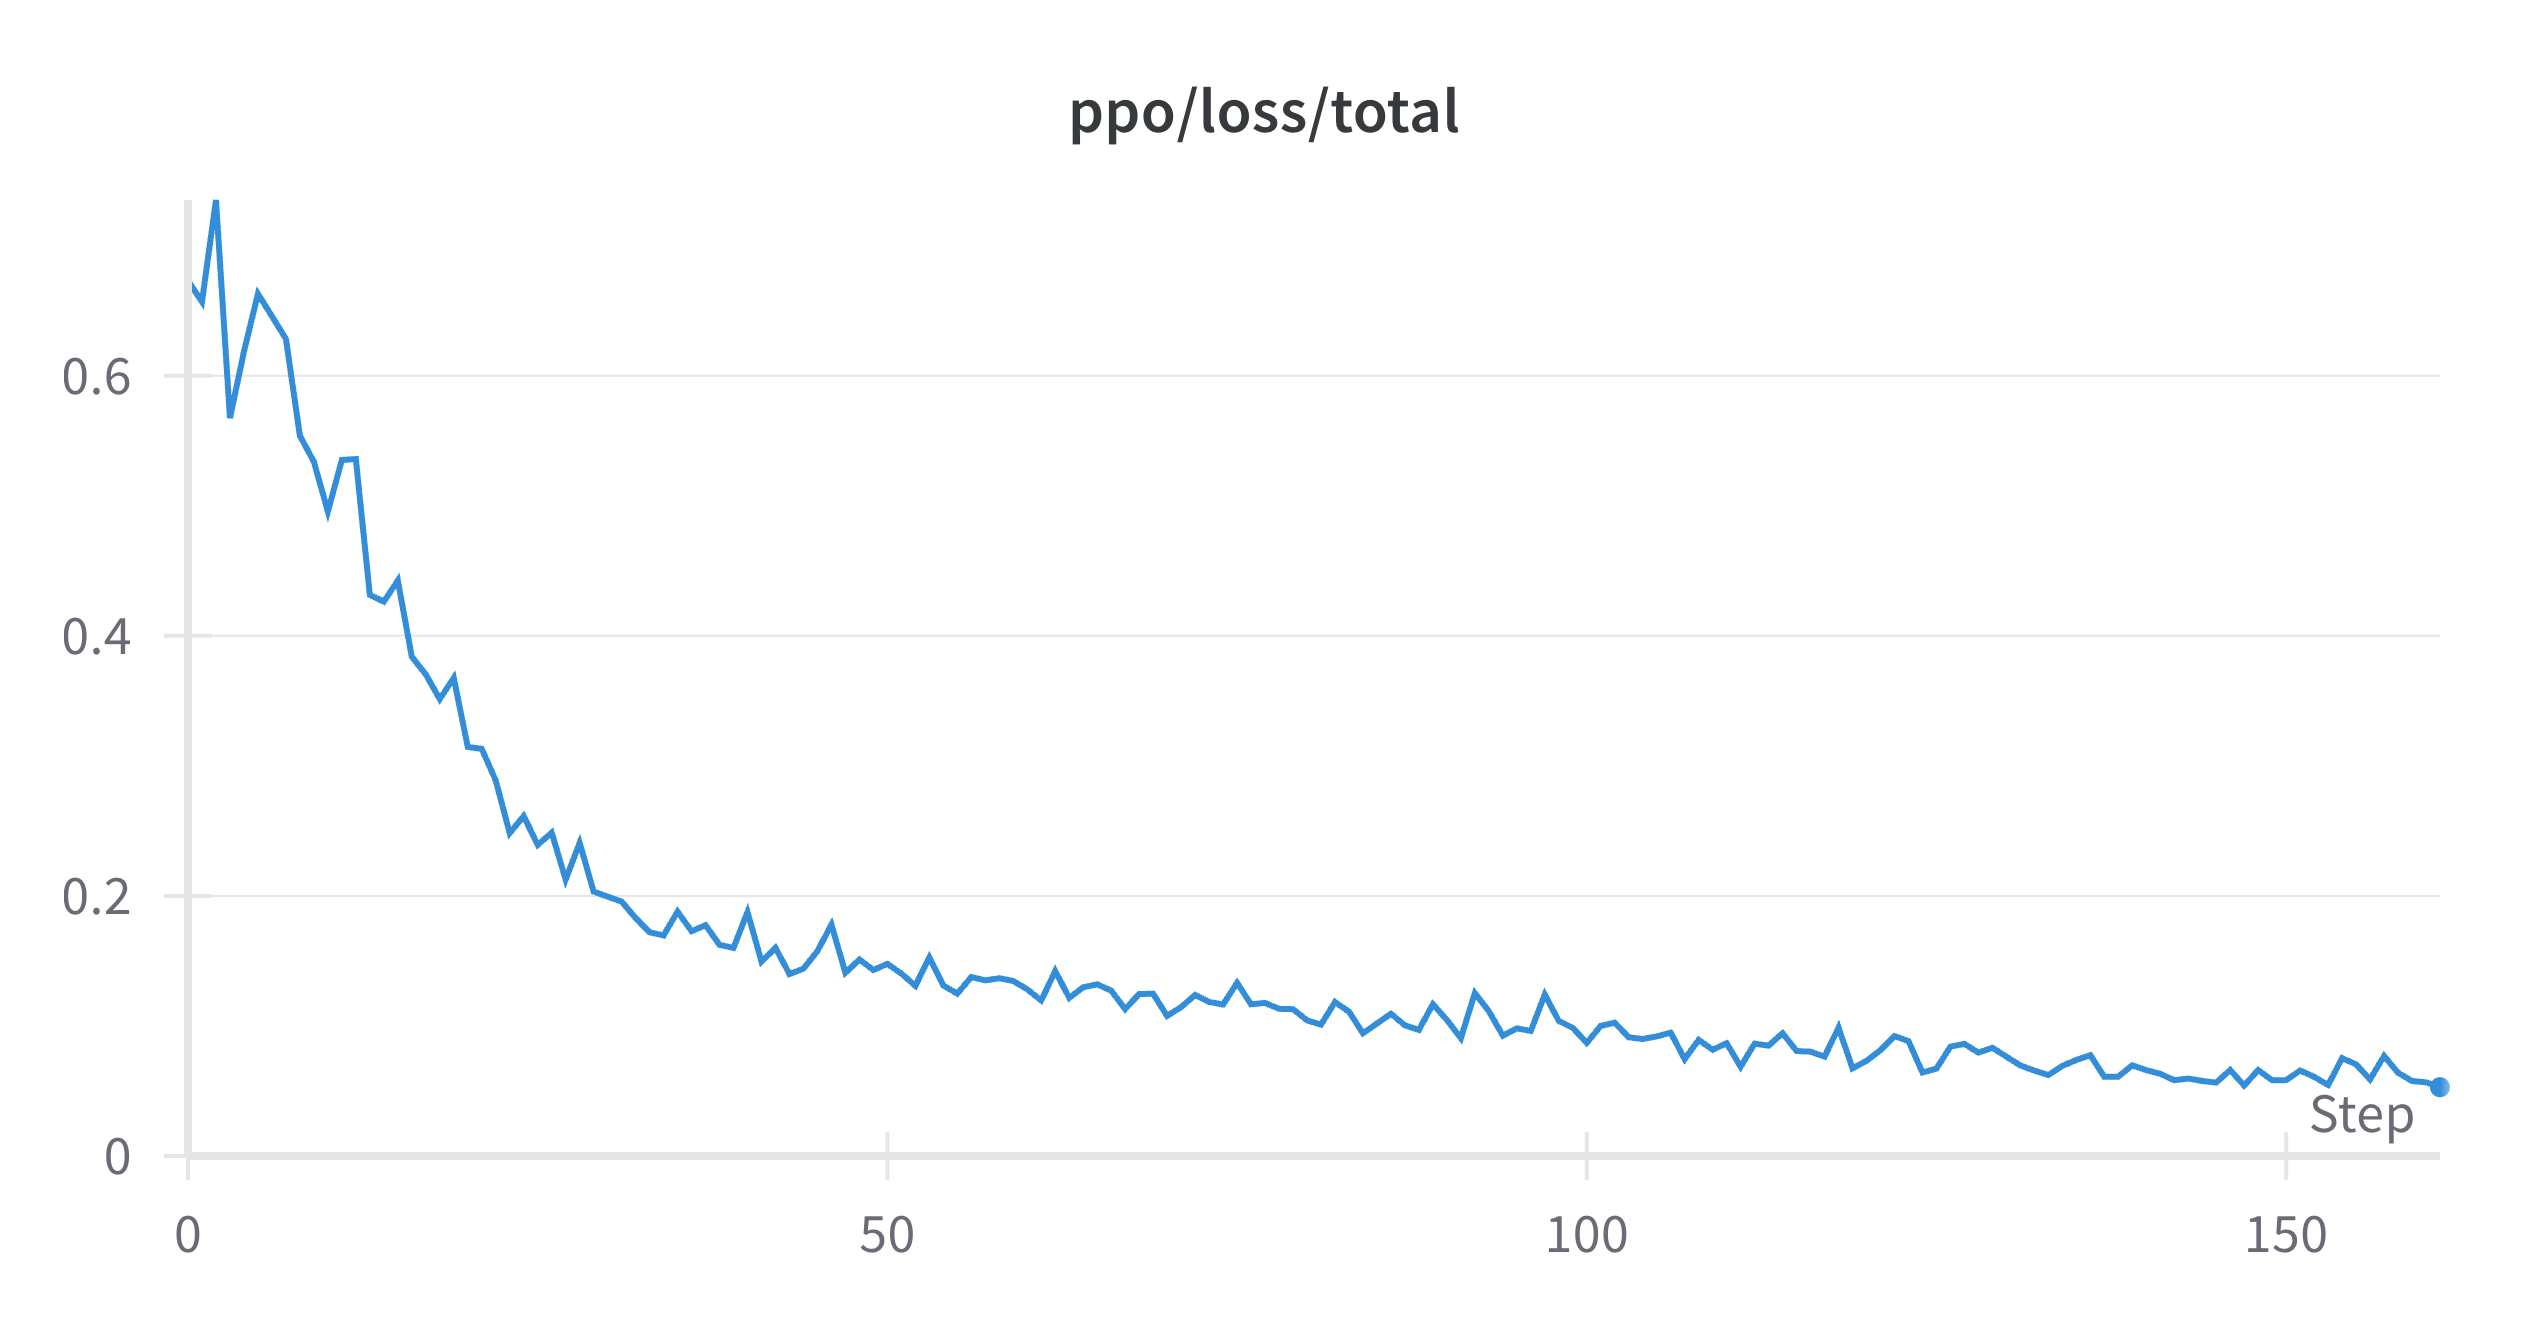


- **ppo_reward.png**: Plots the reward trajectory, demonstrating the effectiveness of the training process over time. From the picture, the mean reward graph shows a positive and stable increase, indicating that the model's performance is consistently improving.
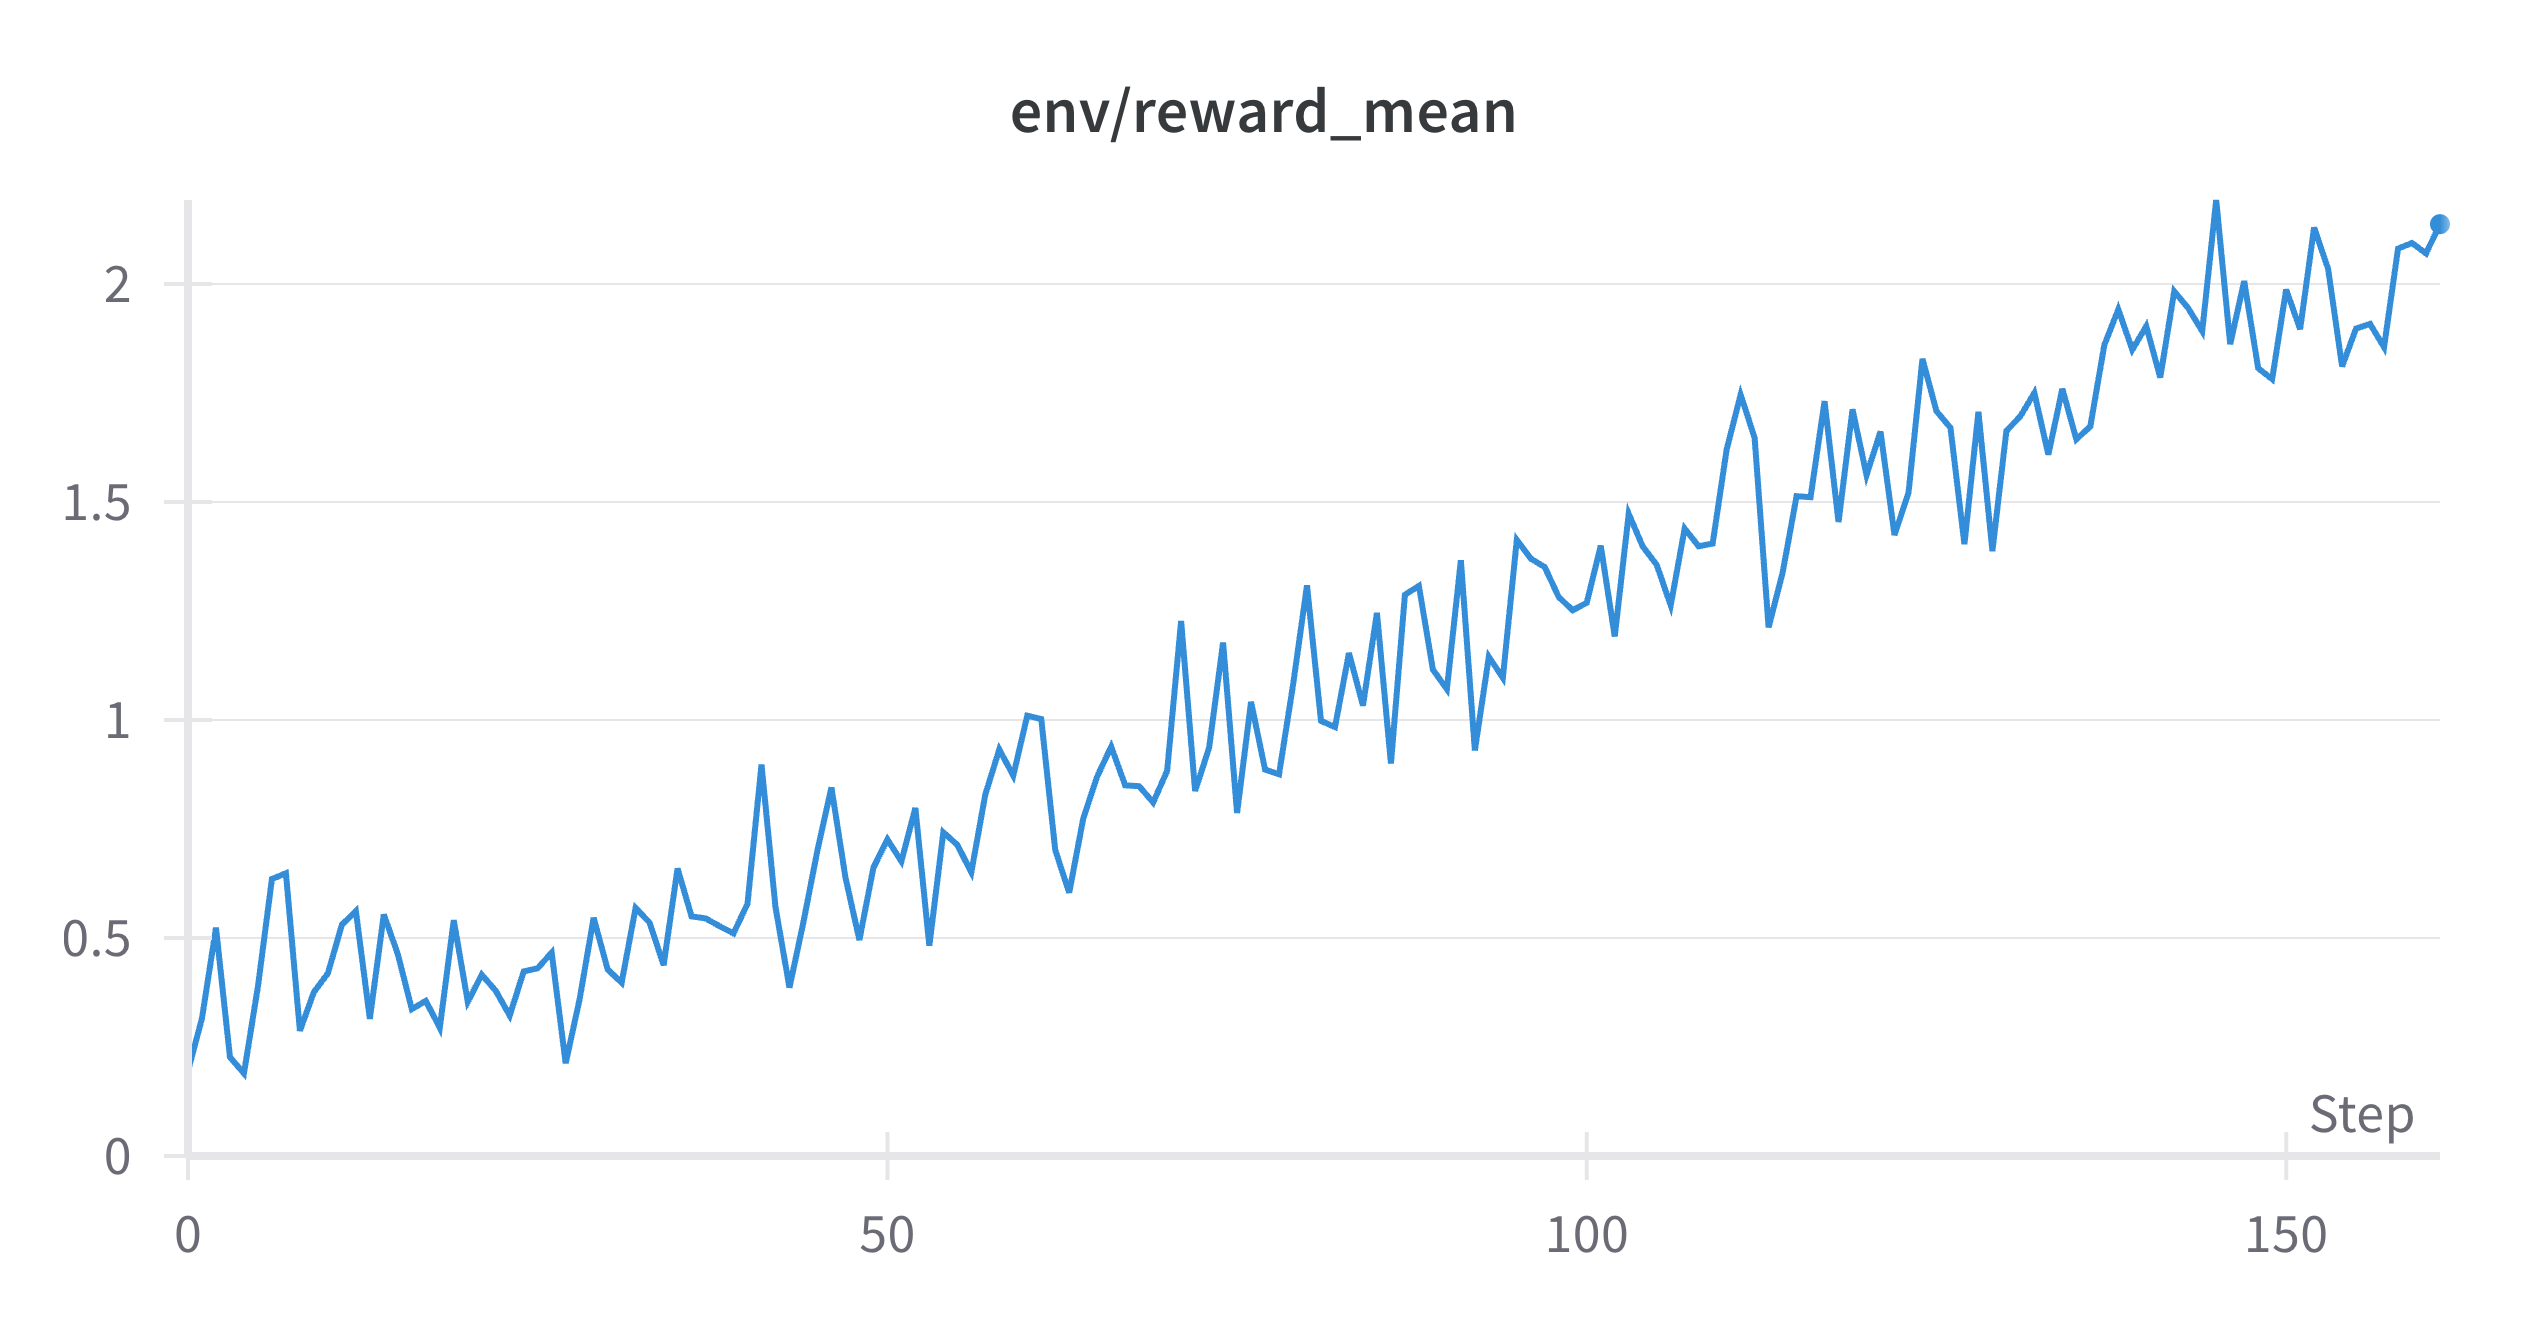